In [75]:
## 
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import json
from pytimekr import pytimekr

##
from model import LTSF_DLinear
from model import LTSF_DLinear_addsupply
from utils import time_slide_df
from utils import Data
from utils import data_split
from utils import min_max_inverse_scaling
from utils import min_max_scaling

In [76]:
else_code = ['BC_C_J', 'CR_B_J', 'RD_E_S', 'BC_A_J', 'CB_F_J', 'RD_D_J', 'BC_E_S', 'CR_D_J', 'BC_A_S', 'BC_B_S', 
             'CR_E_S', 'RD_F_J', 'BC_E_J', 'CR_C_J', 'CR_D_S', 'CB_A_S', 'CR_E_J', 'RD_C_S', 'BC_C_S', 'CB_E_J', 
             'RD_E_J', 'BC_D_J', 'CR_A_J', 'RD_A_S', 'RD_A_J', 'RD_D_S', 'CB_D_J', 'CB_A_J', 'BC_B_J']
TG_code = ['TG_A_J', 'TG_B_J', 'TG_A_S', 'TG_E_J', 'TG_C_J', 'TG_D_J', 'TG_E_S', 'TG_C_S', 'TG_D_S', 'TG_B_S']
unique_code = ['BC_C_J', 'TG_B_J', 'CR_B_J', 'RD_E_S', 'BC_A_J', 'CB_F_J', 'RD_D_J', 'TG_A_S', 'BC_E_S', 'CR_D_J', 'BC_A_S', 'BC_B_S', 'TG_E_J', 
               'CR_E_S', 'RD_F_J', 'BC_E_J', 'TG_A_J', 'CR_C_J', 'CR_D_S', 'TG_C_J', 'CB_A_S', 'TG_D_J', 'CR_E_J', 'RD_C_S', 'BC_C_S', 'CB_E_J', 
               'RD_E_J', 'BC_D_J', 'CR_A_J', 'TG_E_S', 'TG_C_S', 'TG_D_S', 'RD_A_S', 'RD_A_J', 'RD_D_S', 'TG_B_S', 'CB_D_J', 'CB_A_J', 'BC_B_J']

### TG 3월 Supply 예측

In [77]:
def data_split(data):
    ID_split = data['ID'].str.split('_')
    code = []
    for l in ID_split:
        code.append(f"{l[0]}_{l[1]}_{l[2]}")
    unique_code = set(code)

    data_split_list = {}
    for code in unique_code:
        code_parts = code.split('_')
        code_item, code_corporation, code_location = code_parts[0], code_parts[1], code_parts[2]
        
        condition = (data['item'] == code_item) & (data['corporation'] == code_corporation) & (data['location'] == code_location)
        
        data_split_list[f"data_{code}"] = data[condition].reset_index(drop = True)

    return data_split_list

In [78]:
data = pd.read_csv("data/train.csv")
data_list = data_split(data)
TG_code = ['TG_A_J', 'TG_B_J', 'TG_A_S', 'TG_E_J', 'TG_C_J', 'TG_D_J', 'TG_E_S', 'TG_C_S', 'TG_D_S', 'TG_B_S']
# TG_code = ['BC_C_J', 'TG_B_J', 'CR_B_J', 'RD_E_S', 'BC_A_J', 'CB_F_J', 'RD_D_J', 'TG_A_S', 'BC_E_S', 'CR_D_J', 'BC_A_S', 'BC_B_S', 'TG_E_J', 
#                'CR_E_S', 'RD_F_J', 'BC_E_J', 'TG_A_J', 'CR_C_J', 'CR_D_S', 'TG_C_J', 'CB_A_S', 'TG_D_J', 'CR_E_J', 'RD_C_S', 'BC_C_S', 'CB_E_J', 
#                'RD_E_J', 'BC_D_J', 'CR_A_J', 'TG_E_S', 'TG_C_S', 'TG_D_S', 'RD_A_S', 'RD_A_J', 'RD_D_S', 'TG_B_S', 'CB_D_J', 'CB_A_J', 'BC_B_J']

In [79]:
data = pd.read_csv('data/train.csv')


data['year'] = data['timestamp'].str.split('-').str[0]
data['month'] = data['timestamp'].str.split('-').str[1]
data['day'] = data['timestamp'].str.split('-').str[2]
data['weekday'] = pd.to_datetime(data['timestamp']).dt.weekday


data['timestamp'] = pd.to_datetime(data['timestamp'])

## 
data['is_weekend'] = 0
data['is_weekend'][data['weekday']==5] = 1
data['is_weekend'][data['weekday']==6] = 1



holidays_2019 = pytimekr.holidays(year = 2019)
holidays_2020 = pytimekr.holidays(year = 2020)
holidays_2021 = pytimekr.holidays(year = 2021)
holidays_2022 = pytimekr.holidays(year = 2022)
holidays_2023 = pytimekr.holidays(year = 2023)

all_holidays = holidays_2019 + holidays_2020 + holidays_2021 + holidays_2022 + holidays_2023

# 공휴일 여부 변수 추가
data['holiday'] = (data['timestamp'].isin(all_holidays)).astype(int)


# Initialize an empty dictionary to store filtered DataFrames
filtered_data = {}

# Define the list of items, corporations, and locations
items = ['TG', 'BC', 'CR', 'RD', 'CB']
corporations = ['A', 'B', 'C', 'D', 'E', 'F']
locations = ['J', 'S']

# Nested loops to filter the DataFrame for each combination
for item in items:
    for corporation in corporations:
        for location in locations:
            filtered_data_key = f"{item}_{corporation}_{location}"
            filtered_data[filtered_data_key] = data[(data['item'] == item) & (data['corporation'] == corporation) & (data['location'] == location)].drop(columns=['ID', 'item', 'corporation', 'location'], axis=1)


for dataset_code in unique_code:

    # na를 선형보간
    data_list[f"adj_{dataset_code}"] = filtered_data[dataset_code]
    data_list[f"adj_{dataset_code}"]['price(원/kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] != 6) & (data_list[f"adj_{dataset_code}"]['holiday'] != 1) & (data_list[f"adj_{dataset_code}"]['price(원/kg)']==0)] = pd.NA
    data_list[f"adj_{dataset_code}"]['price(원/kg)'] = data_list[f"adj_{dataset_code}"][['price(원/kg)']].interpolate(method='linear')
    data_list[f"adj_{dataset_code}"]['price(원/kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] != 6) & (data_list[f"adj_{dataset_code}"]['holiday'] != 1) & (data_list[f"adj_{dataset_code}"]['price(원/kg)']==0)] = pd.NA
    data_list[f"adj_{dataset_code}"]['price(원/kg)'] = data_list[f"adj_{dataset_code}"]['price(원/kg)'].replace(0, np.nan).fillna(method='ffill').fillna(0)
    # 공휴일, 일요일은 다시 0으로
    data_list[f"adj_{dataset_code}"]['price(원/kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] == 6) | (data_list[f"adj_{dataset_code}"]['holiday'] == 1)] = 0

    # na를 선형보간
    data_list[f"adj_{dataset_code}"]['supply(kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] != 6) & (data_list[f"adj_{dataset_code}"]['holiday'] != 1) & (data_list[f"adj_{dataset_code}"]['supply(kg)']==0)] = pd.NA
    data_list[f"adj_{dataset_code}"]['supply(kg)'] = data_list[f"adj_{dataset_code}"][['supply(kg)']].interpolate(method='linear')
    data_list[f"adj_{dataset_code}"]['supply(kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] != 6) & (data_list[f"adj_{dataset_code}"]['holiday'] != 1) & (data_list[f"adj_{dataset_code}"]['supply(kg)']==0)] = pd.NA
    data_list[f"adj_{dataset_code}"]['supply(kg)'] = data_list[f"adj_{dataset_code}"]['supply(kg)'].replace(0, np.nan).fillna(method='ffill').fillna(0)
    # 공휴일, 일요일은 다시 0으로
    data_list[f"adj_{dataset_code}"]['supply(kg)'][(data_list[f"adj_{dataset_code}"]['weekday'] == 6) | (data_list[f"adj_{dataset_code}"]['holiday'] == 1)] = 0


/var/folders/6r/w8k58h7j3799_jkwn2c_nk7c0000gn/T/ipykernel_19612/1906042453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_weekend'][data['weekday']==5] = 1
/var/folders/6r/w8k58h7j3799_jkwn2c_nk7c0000gn/T/ipykernel_19612/1906042453.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_weekend'][data['weekday']==6] = 1
/var/folders/6r/w8k58h7j3799_jkwn2c_nk7c0000gn/T/ipykernel_19612/1906042453.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [21]:
data_list['data_BC_A_J']['timestamp'][data_list['data_BC_A_J']['timestamp'] == '2022-02-25']

1151    2022-02-25
Name: timestamp, dtype: object

In [15]:
# march_data = {}
# for code in TG_code:
#     march_data[code] = {}
#     march_data[code]['2019'] = data_list[f'data_{code}'][(data_list[f'data_{code}']['timestamp'] >= '2019-02-23') & (data_list[f'data_{code}']['timestamp'] <= '2019-03-31')].reset_index(drop = True)
#     march_data[code]['2020'] = data_list[f'data_{code}'][(data_list[f'data_{code}']['timestamp'] >= '2020-02-29') & (data_list[f'data_{code}']['timestamp'] <= '2020-04-03')].reset_index(drop = True)
#     march_data[code]['2021'] = data_list[f'data_{code}'][(data_list[f'data_{code}']['timestamp'] >= '2021-02-27') & (data_list[f'data_{code}']['timestamp'] <= '2021-04-02')].reset_index(drop = True)
#     march_data[code]['2022'] = data_list[f'data_{code}'][(data_list[f'data_{code}']['timestamp'] >= '2022-02-26') & (data_list[f'data_{code}']['timestamp'] <= '2022-04-01')].reset_index(drop = True)
    
#     avg_supply = []
#     for i in range(28):
#         avg = (march_data[code]['2019']['supply(kg)'][i] + march_data[code]['2020']['supply(kg)'][i] + march_data[code]['2021']['supply(kg)'][i] + march_data[code]['2022']['supply(kg)'][i]) / 4
#         avg_supply.append(avg)
        

#     march_data[code]['avg_supply'] = avg_supply

In [80]:
march_data = {}
for code in unique_code:
    march_data[code] = {}
    march_data[code]['2019'] = data_list[f'data_{code}'][(data_list[f'data_{code}']['timestamp'] >= '2019-03-04') & (data_list[f'data_{code}']['timestamp'] <= '2019-03-31')].reset_index(drop = True)
    march_data[code]['2020'] = data_list[f'data_{code}'][(data_list[f'data_{code}']['timestamp'] >= '2020-03-04') & (data_list[f'data_{code}']['timestamp'] <= '2020-03-31')].reset_index(drop = True)
    march_data[code]['2021'] = data_list[f'data_{code}'][(data_list[f'data_{code}']['timestamp'] >= '2021-03-04') & (data_list[f'data_{code}']['timestamp'] <= '2021-03-31')].reset_index(drop = True)
    march_data[code]['2022'] = data_list[f'data_{code}'][(data_list[f'data_{code}']['timestamp'] >= '2022-03-04') & (data_list[f'data_{code}']['timestamp'] <= '2022-03-31')].reset_index(drop = True)
    

    avg_supply = []
    for i in range(28):
        supply_19 = march_data[code]['2019']['supply(kg)'][i]
        supply_20 = march_data[code]['2020']['supply(kg)'][i] 
        supply_21 = march_data[code]['2021']['supply(kg)'][i] 
        supply_22 =march_data[code]['2022']['supply(kg)'][i] 

        supplies = [supply_19, supply_20, supply_21, supply_22]
        filtered_supplies = [supply for supply in supplies if supply != 0]

        # 평균 계산
        if filtered_supplies:
            average_supply = sum(filtered_supplies) / len(filtered_supplies)
        else: 
            average_supply = 0
        
        avg_supply.append(average_supply)

    zero_sunday = [1, 8, 15, 22]
    for idx in zero_sunday:
        avg_supply[idx] = 0


    avg_price = []
    for i in range(28):
        price_19 = march_data[code]['2019']['price(원/kg)'][i]
        price_20 = march_data[code]['2020']['price(원/kg)'][i] 
        price_21 = march_data[code]['2021']['price(원/kg)'][i] 
        price_22 =march_data[code]['2022']['price(원/kg)'][i] 

        prices = [price_19, price_20, price_21, price_22]
        filtered_prices = [price for price in prices if price != 0]

        # 평균 계산
        if filtered_prices:
            average_price = sum(filtered_prices) / len(filtered_prices)
        else: 
            average_price = 0
        
        avg_price.append(average_price)
        

    zero_sunday = [1, 8, 15, 22]
    for idx in zero_sunday:
        avg_price[idx] = 0


    march_data[code]['avg_supply'] = avg_supply
    march_data[code]['avg_price'] = avg_price

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

scaled_supply, min_supply, max_supply = min_max_scaling(data_list['data_TG_A_J']['supply(kg)'])
data_list['data_TG_A_J']['supply(kg)'] = scaled_supply
scaled_price, min_price, max_price = min_max_scaling(data_list['data_TG_A_J']['price(원/kg)'])
data_list['data_TG_A_J']['price(원/kg)'] = scaled_price


# 데이터를 float64로 변환하여 텐서 생성
X = torch.tensor(data_list['data_TG_A_J']['supply(kg)'], dtype=torch.float64).reshape(-1, 1)  # 생산량
y = torch.tensor(data_list['data_TG_A_J']['price(원/kg)'], dtype=torch.float64).reshape(-1, 1)



# TensorDataset으로 데이터셋 생성
dataset = TensorDataset(X, y)

# 데이터를 1400개와 (전체 데이터 길이 - 1400)개로 나누기
train_size = 1400
train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])

# DataLoader 생성
dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

# 신경망 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 모델, 손실 함수, 최적화 기법 정의
input_size = 1  # 생산량의 특성 수
hidden_size = 64  # 은닉층의 뉴런 수
output_size = 1  # 출력의 크기

model = MLP(input_size, hidden_size, output_size)
model = model.double()  # 모델의 가중치를 float64로 설정
criterion = nn.MSELoss()  # 평균 제곱 오차 사용
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 전환

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 검증 데이터에 대한 성능 평가
    model.eval()  # 모델을 평가 모드로 전환

    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * len(inputs)

    # 전체 검증 데이터에 대한 평균 손실 계산
    average_val_loss = val_loss / len(val_set)

    print(f'Validation Loss: {average_val_loss:.4f}')


Validation Loss: 0.0756
Validation Loss: 0.0762
Validation Loss: 0.0744
Validation Loss: 0.0746
Validation Loss: 0.0734
Validation Loss: 0.0749
Validation Loss: 0.0760
Validation Loss: 0.0738
Validation Loss: 0.0730
Validation Loss: 0.0745
Validation Loss: 0.0744
Validation Loss: 0.0750
Validation Loss: 0.0737
Validation Loss: 0.0747
Validation Loss: 0.0758
Validation Loss: 0.0772
Validation Loss: 0.0749
Validation Loss: 0.0739
Validation Loss: 0.0741
Validation Loss: 0.0738
Validation Loss: 0.0745
Validation Loss: 0.0738
Validation Loss: 0.0786
Validation Loss: 0.0731
Validation Loss: 0.0731
Validation Loss: 0.0738
Validation Loss: 0.0745
Validation Loss: 0.0727
Validation Loss: 0.0736
Validation Loss: 0.0778
Validation Loss: 0.0734
Validation Loss: 0.0742
Validation Loss: 0.0737
Validation Loss: 0.0768
Validation Loss: 0.0723
Validation Loss: 0.0749
Validation Loss: 0.0738
Validation Loss: 0.0757
Validation Loss: 0.0743
Validation Loss: 0.0751
Validation Loss: 0.0744
Validation Loss:

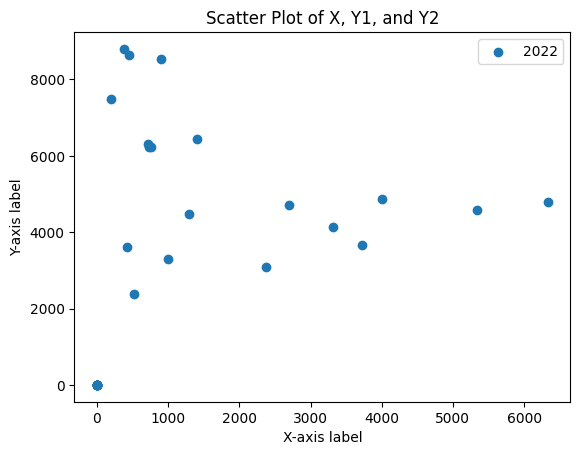

In [91]:
data = march_data['TG_B_J']



# 산점도 그리기
# plt.scatter(range(28), data['2022']['price(원/kg)'], label='avg')
# plt.scatter(range(28), data['2022']['supply(kg)'], label='2022')

plt.scatter(data['2022']['supply(kg)'], data['2022']['price(원/kg)'], label='2022')

plt.title('Scatter Plot of X, Y1, and Y2')
plt.xlabel('')
plt.ylabel('Y-axis label')
plt.legend()  # 범례 추가
plt.show()

In [68]:
march_data['TG_B_J']['avg_supply']

[6610.5,
 0,
 9254.666666666666,
 6759.666666666667,
 5346.0,
 6923.0,
 7637.0,
 5991.5,
 0,
 6632.333333333333,
 5563.666666666667,
 4255.0,
 4679.0,
 3767.6666666666665,
 7303.5,
 0,
 4484.0,
 1844.3333333333333,
 2385.0,
 3072.84,
 5232.4,
 1688.3333333333333,
 0,
 3065.0,
 1341.5,
 688.5,
 1864.625,
 6526.8]

In [84]:
pred_TG = {}
RMSE_list = []

# for i in tqdm(range(len(TG_code))):
for i in tqdm(range(len(TG_code))):

    ## prepare dataset for training
    dataset_code = TG_code[i]

    if dataset_code in ['TG_B_J','TG_E_J','TG_D_J']:
        df = data_list[f'adj_{dataset_code}'].reset_index(drop=True)
    
    else:
        df = data_list[f'data_{dataset_code}'].reset_index(drop=True)
    print(len(df))
    
    march_supply = march_data[dataset_code]['2022']['supply(kg)']




    # df = df.drop(['ID', 'item', 'corporation', 'location'], axis=1)
    # test_df = test_df.drop(['ID', 'item', 'corporation', 'location'], axis=1)

    # scaling
    scaled_supply, min_supply, max_supply = min_max_scaling(df['supply(kg)'])
    df['supply(kg)'] = scaled_supply
    scaled_price, min_price, max_price = min_max_scaling(df['price(원/kg)'])
    df['price(원/kg)'] = scaled_price

    scaled_march_supply = (march_supply- min_supply) / (max_supply - min_supply)



    # scaled_x, mean_data, std_data = z_score(df['price(원/kg)'])
    # df['price(원/kg)'] = scaled_x

    
    # 날짜 변환
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # train, valid split
    # 22년 2월 25일 ~ 3월 24일 = valid -> 3월 4일 ~ 3월 31일 예측
    valid = df.iloc[1152:1152+35].reset_index(drop = True)


    # 나머지 행을 포함하는 데이터프레임
    train = df.drop(valid.index).reset_index(drop = True)


    print("Dataset prepared")
    print()

    ## paramaters
    window_size = 7
    forcast_size= 1
    batch_size = 32
    target = ['supply(kg)', 'price(원/kg)']
    date = 'timestamp'

    print("Start preprocessing")
    print()
 


    train_x, train_y= time_slide_df(train, window_size, forcast_size, target)
    valid_x, valid_y = time_slide_df(valid, window_size, forcast_size, target)



    train_ds = Data(train_x, train_y)
    valid_ds = Data(valid_x, valid_y)


    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
    valid_dl = DataLoader(valid_ds, batch_size = valid_x.shape[0], shuffle=False)

    print("Success preprocessing")


    print("Paramater for training")
    print()
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    epochs = 100
    lr = 0.001
    # model paramater
    DLinear_multi_model = LTSF_DLinear_addsupply(
                                            window_size=window_size,
                                            forcast_size=forcast_size,
                                            kernel_size=25,
                                            hidden_size=10
                                            )
    # Loss
    criterion = torch.nn.MSELoss()
    # optimizer
    optimizer = torch.optim.Adam(DLinear_multi_model.parameters(), lr=lr)
    
    # early stopping
    early_stopping_epochs = 5
    best_loss = 99999
    early_stop_counter = 0

    print("strat training")
    print()


    for epoch in tqdm(range(1, epochs+1)):
        loss_list = []
        DLinear_multi_model.train()
        for batch_eeeeidx, (data, target) in enumerate(train_dl): # data.shape (32,7,2), target.shape (32,1,2)
            optimizer.zero_grad()
            output = DLinear_multi_model(data) # output.shape (32,1)
            loss = criterion(output, target[:,:,1].reshape(-1,1))
            loss.backward()
            optimizer.step()
            loss_list.append(np.sqrt(loss.item()))  
        train_loss_list.append(np.sqrt(np.mean(loss_list)))

        DLinear_multi_model.eval()
        with torch.no_grad():
            for data, target in valid_dl:
                output = DLinear_multi_model(data)
                output = min_max_inverse_scaling(output, min_price, max_price)
                zero_sunday = [1, 8, 15, 22]
                for idx in zero_sunday:
                    output[idx] = 0
                target = min_max_inverse_scaling(target, min_price, max_price)
                valid_loss = np.sqrt(criterion(output, target[:,:,1].reshape(-1,1)))
                valid_loss_list.append(np.sqrt(valid_loss.item()))

  

        if valid_loss > best_loss:
            early_stop_counter += 1
        else:
            best_loss = valid_loss
            early_stop_counter = 0

        # 조기 종료 조건 확인
        if early_stop_counter >= early_stopping_epochs or epoch == epochs:
            print(f"Early Stopping epoch:{epoch}")
            print(f"{dataset_code}")
            print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss))
        
            data = valid_y[-window_size:,:,:]
            pred_value = np.array([])
            for i in range(28):
                pred_input = torch.Tensor(data).reshape(1,window_size,2)
                pred_output = DLinear_multi_model(pred_input)
                

                new_value = np.array([[[scaled_march_supply[i], pred_output.item()]]])

                data = np.concatenate((data, new_value), axis=0)
                pred_value = np.append(pred_value,pred_output.item())
                data = data[1:]

            # pred_TG[dataset_code] = pred_value
            # rescaling pred
            pred_TG[dataset_code] = min_max_inverse_scaling(pred_value, min_price, max_price)
            # print(f"지난 4년 3월 평균가격 for {dataset_code}: {np.mean(march_data[dataset_code]['avg_price'])}")
            # print(f"3월 예측값 for {dataset_code}")
            print(pred_TG[dataset_code])
            zero_sunday = [1, 8, 15, 22]
            for idx in zero_sunday:
                pred_TG[dataset_code][idx] = 0
            
            
            print(pred_TG[dataset_code])



            # result = [(pred - true) ** 2 for pred, true in zip(pred_TG[dataset_code], march_data[dataset_code]['avg_price'])]
            # mse = sum(result) / len(result)
            # pred_RMSE = mse ** 0.5
            # RMSE_list.append(pred_RMSE)
            # print(f"예상 RMSE: {pred_RMSE}")


            break
            
        
        if epoch % 10 == 0:
            print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss))


# print(np.mean(RMSE_list))


  0%|          | 0/10 [00:00<?, ?it/s]

1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 10, train_loss : 0.203, valid_loss : 1814.527


epoch = 20, train_loss : 0.175, valid_loss : 1654.880


epoch = 30, train_loss : 0.171, valid_loss : 1620.503


epoch = 40, train_loss : 0.170, valid_loss : 1610.403


epoch = 50, train_loss : 0.170, valid_loss : 1598.139


epoch = 60, train_loss : 0.170, valid_loss : 1585.489


epoch = 70, train_loss : 0.170, valid_loss : 1576.646


epoch = 80, train_loss : 0.170, valid_loss : 1569.006


epoch = 90, train_loss : 0.171, valid_loss : 1564.075


 10%|█         | 1/10 [00:08<01:17,  8.61s/it]

Early Stopping epoch:100
TG_A_J
epoch = 100, train_loss : 0.171, valid_loss : 1560.710
[5243.66248679 3333.98312783 5797.2021687  5753.85704613 5458.80870438
 5159.05635977 4734.04729486 4833.34165859 4325.34318423 5272.10799599
 5259.89384294 5033.67092991 4973.44078803 4809.24611378 4859.11914778
 4740.0188601  5123.22243381 5081.30009246 5006.5477457  4983.91404843
 4924.45407104 4950.28667164 4959.20111632 5091.8629961  5093.84107709
 5023.80005813 5046.12854981 5019.41277146]
[5243.66248679    0.         5797.2021687  5753.85704613 5458.80870438
 5159.05635977 4734.04729486 4833.34165859    0.         5272.10799599
 5259.89384294 5033.67092991 4973.44078803 4809.24611378 4859.11914778
    0.         5123.22243381 5081.30009246 5006.5477457  4983.91404843
 4924.45407104 4950.28667164    0.         5091.8629961  5093.84107709
 5023.80005813 5046.12854981 5019.41277146]
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 10, train_loss : 0.125, valid_loss : 1878.881


 20%|██        | 2/10 [00:11<00:40,  5.01s/it]

Early Stopping epoch:19
TG_B_J
epoch = 19, train_loss : 0.118, valid_loss : 1876.074
[4174.71644282 1447.88822532 6430.83673716 7192.50357151 7572.29053974
 7899.01971817 6926.58776045 4730.58500886 2457.15239644 5336.01209521
 6147.39435911 6614.82656002 7144.56760883 6718.39594841 5092.45914221
 3312.82567978 4845.38677335 5482.01826215 5979.96252775 6514.59604502
 6426.7911911  5308.56266618 3932.05225468 4638.80473375 5084.86241102
 5486.11146212 6009.67338681 6098.40652347]
[4174.71644282    0.         6430.83673716 7192.50357151 7572.29053974
 7899.01971817 6926.58776045 4730.58500886    0.         5336.01209521
 6147.39435911 6614.82656002 7144.56760883 6718.39594841 5092.45914221
    0.         4845.38677335 5482.01826215 5979.96252775 6514.59604502
 6426.7911911  5308.56266618    0.         4638.80473375 5084.86241102
 5486.11146212 6009.67338681 6098.40652347]
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 10, train_loss : 0.143, valid_loss : 1040.724


epoch = 20, train_loss : 0.111, valid_loss : 806.436


epoch = 30, train_loss : 0.098, valid_loss : 747.441


epoch = 40, train_loss : 0.092, valid_loss : 723.970


epoch = 50, train_loss : 0.088, valid_loss : 661.685


epoch = 60, train_loss : 0.087, valid_loss : 589.566


epoch = 70, train_loss : 0.086, valid_loss : 544.757


epoch = 80, train_loss : 0.085, valid_loss : 523.748


epoch = 90, train_loss : 0.085, valid_loss : 517.837


 30%|███       | 3/10 [00:19<00:46,  6.71s/it]

Early Stopping epoch:99
TG_A_S
epoch = 99, train_loss : 0.085, valid_loss : 519.032
[5058.33602607  663.06728527 4601.66965008 4595.44480383 4960.12824386
 5200.48121288 4862.79009819 4962.3763147  1220.07118486 4192.37695083
 4320.41507795 4640.70591301 4942.78646842 4702.54522353 4844.89196673
 1675.21701798 3887.7150394  4090.28562248 4371.70060933 4703.30879763
 4544.35139269 4722.59819657 2046.13285318 3668.95351499 3898.6798577
 4131.52315289 4471.71560496 4385.75407162]
[5058.33602607    0.         4601.66965008 4595.44480383 4960.12824386
 5200.48121288 4862.79009819 4962.3763147     0.         4192.37695083
 4320.41507795 4640.70591301 4942.78646842 4702.54522353 4844.89196673
    0.         3887.7150394  4090.28562248 4371.70060933 4703.30879763
 4544.35139269 4722.59819657    0.         3668.95351499 3898.6798577
 4131.52315289 4471.71560496 4385.75407162]
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 10, train_loss : 0.154, valid_loss : 2001.587


 40%|████      | 4/10 [00:22<00:29,  4.96s/it]

Early Stopping epoch:15
TG_E_J
epoch = 15, train_loss : 0.149, valid_loss : 2017.281
[4818.97697449 2399.52719212 2751.92935467 3737.261343   4067.63236523
 4835.82491875 3817.39833355 4626.91853046 3514.36934471 3375.73225498
 3751.41246319 3769.92170811 4493.45812798 3933.34844112 4387.58616447
 3948.01747799 3758.81083012 3855.27815819 3816.73133373 4275.05970001
 4002.10397243 4274.64778423 4130.06534576 3968.15640926 4032.20667839
 3936.80803776 4159.89499092 4069.09995079]
[4818.97697449    0.         2751.92935467 3737.261343   4067.63236523
 4835.82491875 3817.39833355 4626.91853046    0.         3375.73225498
 3751.41246319 3769.92170811 4493.45812798 3933.34844112 4387.58616447
    0.         3758.81083012 3855.27815819 3816.73133373 4275.05970001
 4002.10397243 4274.64778423    0.         3968.15640926 4032.20667839
 3936.80803776 4159.89499092 4069.09995079]
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 10, train_loss : 0.105, valid_loss : 1358.569


 50%|█████     | 5/10 [00:24<00:20,  4.03s/it]

Early Stopping epoch:18
TG_C_J
epoch = 18, train_loss : 0.101, valid_loss : 1359.693
[5859.04337466 3102.60384189 5718.46559128 5685.48545519 5596.90095669
 5614.07709831 6296.09031063 5625.45557553 4362.34708367 5460.29567015
 5620.0473716  5502.40351349 5690.78398705 5934.39182526 5584.44445288
 4863.40138124 5509.00751686 5609.16179556 5613.84279889 5671.66116619
 5902.92092639 5614.9856317  5298.29756069 5593.89930692 5713.16082805
 5706.9469083  5760.19643688 5847.63997197]
[5859.04337466    0.         5718.46559128 5685.48545519 5596.90095669
 5614.07709831 6296.09031063 5625.45557553    0.         5460.29567015
 5620.0473716  5502.40351349 5690.78398705 5934.39182526 5584.44445288
    0.         5509.00751686 5609.16179556 5613.84279889 5671.66116619
 5902.92092639 5614.9856317     0.         5593.89930692 5713.16082805
 5706.9469083  5760.19643688 5847.63997197]
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 10, train_loss : 0.135, valid_loss : 1960.863


epoch = 20, train_loss : 0.120, valid_loss : 1872.826


 60%|██████    | 6/10 [00:27<00:14,  3.70s/it]

Early Stopping epoch:26
TG_D_J
epoch = 26, train_loss : 0.119, valid_loss : 1878.939
[5922.09259415 1440.81080438 7305.57318234 5959.61671722 5045.90365881
 4872.46173102 5033.644328   5243.29086703 2297.84550016 5603.9332982
 5517.89818642 4652.40428039 4650.3349624  4545.41208628 5030.7833029
 3108.75039312 4630.5900667  4963.90867907 4429.70413059 4330.66208714
 4307.52211323 4649.11946779 3484.18569133 4037.4246574  4526.12405777
 4270.65076259 4146.26600584 3929.88260543]
[5922.09259415    0.         7305.57318234 5959.61671722 5045.90365881
 4872.46173102 5033.644328   5243.29086703    0.         5603.9332982
 5517.89818642 4652.40428039 4650.3349624  4545.41208628 5030.7833029
    0.         4630.5900667  4963.90867907 4429.70413059 4330.66208714
 4307.52211323 4649.11946779    0.         4037.4246574  4526.12405777
 4270.65076259 4146.26600584 3929.88260543]
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



 70%|███████   | 7/10 [00:29<00:09,  3.06s/it]

Early Stopping epoch:9
TG_E_S
epoch = 9, train_loss : 0.125, valid_loss : 804.896
[3463.50611079 2417.60406312 3824.66973075 4183.93898749 4126.76737002
 4032.93096614 4024.04576308 3363.39816642 2968.60518859 3580.91656753
 3815.93632668 3702.99934584 3793.11428529 3676.11364907 3385.41159332
 3321.48841238 3623.17512846 3643.84037447 3584.32414252 3697.53017145
 3648.20615762 3606.03764695 3539.14538062 3711.2905848  3654.43322432
 3633.39013481 3697.46401209 3684.164509  ]
[3463.50611079    0.         3824.66973075 4183.93898749 4126.76737002
 4032.93096614 4024.04576308 3363.39816642    0.         3580.91656753
 3815.93632668 3702.99934584 3793.11428529 3676.11364907 3385.41159332
    0.         3623.17512846 3643.84037447 3584.32414252 3697.53017145
 3648.20615762 3606.03764695    0.         3711.2905848  3654.43322432
 3633.39013481 3697.46401209 3684.164509  ]
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 10, train_loss : 0.125, valid_loss : 1046.372


epoch = 20, train_loss : 0.104, valid_loss : 793.091


epoch = 30, train_loss : 0.099, valid_loss : 683.414


epoch = 40, train_loss : 0.098, valid_loss : 654.336


epoch = 50, train_loss : 0.098, valid_loss : 648.087


 80%|████████  | 8/10 [00:34<00:07,  3.88s/it]

Early Stopping epoch:60
TG_C_S
epoch = 60, train_loss : 0.098, valid_loss : 647.826
[5353.15802023 1320.68677696 5222.35143009 5256.99855489 5401.78570288
 5425.94986308 5522.7163581  5126.59287614 2290.84468251 4860.71312284
 5023.0750635  5199.27939481 5177.09336615 5341.57424808 4955.09453484
 2973.92936382 4656.97425762 4864.77584261 5019.45666832 4990.42419052
 5188.52802342 4865.59276563 3443.83790696 4525.50703195 4756.53127712
 4865.21827966 4835.98383614 4993.79380924]
[5353.15802023    0.         5222.35143009 5256.99855489 5401.78570288
 5425.94986308 5522.7163581  5126.59287614    0.         4860.71312284
 5023.0750635  5199.27939481 5177.09336615 5341.57424808 4955.09453484
    0.         4656.97425762 4864.77584261 5019.45666832 4990.42419052
 5188.52802342 4865.59276563    0.         4525.50703195 4756.53127712
 4865.21827966 4835.98383614 4993.79380924]
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 10, train_loss : 0.135, valid_loss : 808.877


 90%|█████████ | 9/10 [00:37<00:03,  3.51s/it]

epoch = 20, train_loss : 0.127, valid_loss : 801.876
Early Stopping epoch:21
TG_D_S
epoch = 21, train_loss : 0.127, valid_loss : 803.074
[4810.33325529 2025.00017577 4560.7522763  4570.58628631 4130.90514493
 4874.0820576  4787.60761714 4302.66104758 2821.44304258 4200.27286398
 4263.0609076  3871.80352557 4367.23584151 4324.56286776 3989.87142134
 3189.6847837  4147.31484532 4097.8546114  3938.51285577 4223.05610418
 4298.72345853 4065.39458942 3746.63137722 4255.34223318 4239.17163563
 3949.83183932 4157.2108047  4239.80235994]
[4810.33325529    0.         4560.7522763  4570.58628631 4130.90514493
 4874.0820576  4787.60761714 4302.66104758    0.         4200.27286398
 4263.0609076  3871.80352557 4367.23584151 4324.56286776 3989.87142134
    0.         4147.31484532 4097.8546114  3938.51285577 4223.05610418
 4298.72345853 4065.39458942    0.         4255.34223318 4239.17163563
 3949.83183932 4157.2108047  4239.80235994]
1523
Dataset prepared

Start preprocessing

Success preprocessing

epoch = 10, train_loss : 0.134, valid_loss : 750.383


epoch = 20, train_loss : 0.112, valid_loss : 631.471


epoch = 30, train_loss : 0.107, valid_loss : 603.327


epoch = 40, train_loss : 0.105, valid_loss : 586.001


epoch = 50, train_loss : 0.105, valid_loss : 579.511


100%|██████████| 10/10 [00:42<00:00,  4.29s/it]

Early Stopping epoch:54
TG_B_S
epoch = 54, train_loss : 0.105, valid_loss : 581.985
[4920.0868082   961.2735939  4261.69137478 5047.68167138 4551.58408165
 4464.57754612 4909.65283155 4466.79243207 1710.3591156  3891.92634583
 4653.84470105 4247.28100777 4244.80876923 4664.77719069 4191.66769862
 2288.30326974 3785.64007044 4458.35009575 4098.88123751 4149.39262629
 4383.15766335 4202.86201954 2704.61862803 3787.2055459  4356.61417246
 4036.59433126 4062.81466722 4252.96412468]
[4920.0868082     0.         4261.69137478 5047.68167138 4551.58408165
 4464.57754612 4909.65283155 4466.79243207    0.         3891.92634583
 4653.84470105 4247.28100777 4244.80876923 4664.77719069 4191.66769862
    0.         3785.64007044 4458.35009575 4098.88123751 4149.39262629
 4383.15766335 4202.86201954    0.         3787.2055459  4356.61417246
 4036.59433126 4062.81466722 4252.96412468]


In [85]:
pred_TG['TG_A_J']

array([5243.66248679,    0.        , 5797.2021687 , 5753.85704613,
       5458.80870438, 5159.05635977, 4734.04729486, 4833.34165859,
          0.        , 5272.10799599, 5259.89384294, 5033.67092991,
       4973.44078803, 4809.24611378, 4859.11914778,    0.        ,
       5123.22243381, 5081.30009246, 5006.5477457 , 4983.91404843,
       4924.45407104, 4950.28667164,    0.        , 5091.8629961 ,
       5093.84107709, 5023.80005813, 5046.12854981, 5019.41277146])

### 그 외 것들

In [61]:
from model import LTSF_NLinear

else_code = ['BC_C_J', 'CR_B_J', 'RD_E_S', 'BC_A_J', 'CB_F_J', 'RD_D_J', 'BC_E_S', 'CR_D_J', 'BC_A_S', 'BC_B_S', 
             'CR_E_S', 'RD_F_J', 'BC_E_J', 'CR_C_J', 'CR_D_S', 'CB_A_S', 'CR_E_J', 'RD_C_S', 'BC_C_S', 'CB_E_J', 
             'RD_E_J', 'BC_D_J', 'CR_A_J', 'RD_A_S', 'RD_A_J', 'RD_D_S', 'CB_D_J', 'CB_A_J', 'BC_B_J']

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)



pred_else = {}

# for i in tqdm(range(len(else_code))):
for i in tqdm(range(len(else_code))):

    ## prepare dataset for training
    dataset_code = else_code[i]

    train_df = data_list[f'data_{dataset_code}'].reset_index(drop=True)
    print(len(train_df))

    # train_df = train_df.drop(['ID', 'item', 'corporation', 'location'], axis=1)
    # test_df = test_df.drop(['ID', 'item', 'corporation', 'location'], axis=1)

    # scaling
    scaled_x, min_val, max_val = min_max_scaling(train_df['price(원/kg)'])
    train_df['price(원/kg)'] = scaled_x
    # scaled_x, mean_data, std_data = z_score(train_df['price(원/kg)'])
    # train_df['price(원/kg)'] = scaled_x

    train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
    print("Dataset prepared")
    print()

    ## paramaters
    window_size = 7
    forcast_size= 1
    batch_size = 32
    targets = 'price(원/kg)'
    date = 'timestamp'
    not_col = 'timestamp'

    print("Start preprocessing")
    print()
    # train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, not_col, targets)
    # train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
    # test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)

    train_x, train_y, train_date = time_slide_df(train_df, window_size, forcast_size, date, targets)
    # test_x, test_y, test_date = time_slide_df(test_df, window_size, forcast_size, date, targets)


    train_ds = Data(train_x[:1400], train_y[:1400])
    valid_ds = Data(train_x[1400:], train_y[1400:])
    # test_ds = Data(test_x, test_y)

    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)
    valid_dl = DataLoader(valid_ds, batch_size = train_x[1400:].shape[0], shuffle=False)
    # test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)
    print("Success preprocessing")


    print("Paramater for training")
    print()
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    epochs = 60
    lr = 0.001
    NLinear_model = LTSF_NLinear(
                                window_size = window_size, 
                                forcast_size = forcast_size, 
                                individual = False, 
                                feature_size = 1
                                )
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(NLinear_model.parameters(), lr=lr)
    max_loss = 999999999

    print("strat training")
    print()


    for epoch in tqdm(range(1, epochs+1)):
        loss_list = []
        NLinear_model.train()
        for batch_eeeeidx, (data, target) in enumerate(train_dl):
            optimizer.zero_grad()
            output = NLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            loss_list.append(np.sqrt(loss.item()))  
        train_loss_list.append(np.sqrt(np.mean(loss_list)))

        NLinear_model.eval()
        with torch.no_grad():
            for data, target in valid_dl:
                output = NLinear_model(data)
                valid_loss = np.sqrt(criterion(output, target.unsqueeze(-1)).item())
                valid_loss_list.append(np.sqrt(valid_loss.item()))
            
        if epoch == epochs:
            data = train_y[-7:].reshape(1,-1)
            pred_value = np.array([])
            for i in range(28):
                pred_input = torch.Tensor(data).reshape(1,7,1)
                pred_output = NLinear_model(pred_input)
                data = np.append(data,pred_output.item())
                pred_value = np.append(pred_value,pred_output.item())
                data = data[1:]

            # pred[dataset_code] = pred_value
            # rescaling pred
            pred_else[dataset_code] = min_max_inverse_scaling(pred_value, min_val, max_val)
            # pred[dataset_code] = z_score_inverse(pred_value, mean_data, std_data)

            # for data, target in test_dl:
            #     output = NLinear_model(data)
            #     test_loss = criterion(output, target.unsqueeze(-1))
            #     test_loss_list.append(test_loss)

        # if valid_loss < max_loss:
        #     torch.save(NLinear_model, f'NLinear_model_{dataset_code}.pth')
        #     max_loss = valid_loss
        #     # print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        #     print("valid_loss={:.3f}, Model Save".format(valid_loss))
        #     dlinear_best_epoch = epoch
        #     dlinear_best_train_loss = np.mean(loss_list)
        #     dlinear_best_valid_loss = np.mean(valid_loss.item())

        # print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))
        
        if epoch % 20 == 0:
            print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss))

  0%|          | 0/29 [00:00<?, ?it/s]

1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.146, valid_loss : 0.144


epoch = 40, train_loss : 0.142, valid_loss : 0.141


  3%|▎         | 1/29 [00:02<01:00,  2.15s/it]

epoch = 60, train_loss : 0.142, valid_loss : 0.142
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.103, valid_loss : 0.279


epoch = 40, train_loss : 0.101, valid_loss : 0.272


  7%|▋         | 2/29 [00:04<00:58,  2.16s/it]

epoch = 60, train_loss : 0.102, valid_loss : 0.271
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.096, valid_loss : 0.163


epoch = 40, train_loss : 0.094, valid_loss : 0.162


 10%|█         | 3/29 [00:06<00:55,  2.12s/it]

epoch = 60, train_loss : 0.094, valid_loss : 0.162
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.137, valid_loss : 0.135


epoch = 40, train_loss : 0.122, valid_loss : 0.122


 14%|█▍        | 4/29 [00:08<00:51,  2.08s/it]

epoch = 60, train_loss : 0.121, valid_loss : 0.121
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.101, valid_loss : 0.114


epoch = 40, train_loss : 0.091, valid_loss : 0.106


 17%|█▋        | 5/29 [00:10<00:49,  2.06s/it]

epoch = 60, train_loss : 0.090, valid_loss : 0.106
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.118, valid_loss : 0.130


epoch = 40, train_loss : 0.113, valid_loss : 0.130


 21%|██        | 6/29 [00:12<00:46,  2.04s/it]

epoch = 60, train_loss : 0.114, valid_loss : 0.131
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.134, valid_loss : 0.148


epoch = 40, train_loss : 0.131, valid_loss : 0.146


 24%|██▍       | 7/29 [00:14<00:45,  2.05s/it]

epoch = 60, train_loss : 0.129, valid_loss : 0.146
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.094, valid_loss : 0.251


epoch = 40, train_loss : 0.091, valid_loss : 0.250


 28%|██▊       | 8/29 [00:16<00:44,  2.10s/it]

epoch = 60, train_loss : 0.091, valid_loss : 0.253
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.154, valid_loss : 0.159


epoch = 40, train_loss : 0.140, valid_loss : 0.142


 31%|███       | 9/29 [00:18<00:42,  2.11s/it]

epoch = 60, train_loss : 0.138, valid_loss : 0.139
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.102, valid_loss : 0.088


epoch = 40, train_loss : 0.098, valid_loss : 0.086


 34%|███▍      | 10/29 [00:20<00:39,  2.08s/it]

epoch = 60, train_loss : 0.095, valid_loss : 0.086
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.068, valid_loss : 0.000


epoch = 40, train_loss : 0.065, valid_loss : 0.001


 38%|███▊      | 11/29 [00:22<00:37,  2.06s/it]

epoch = 60, train_loss : 0.065, valid_loss : 0.002
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.100, valid_loss : 0.131


epoch = 40, train_loss : 0.098, valid_loss : 0.129


 41%|████▏     | 12/29 [00:25<00:35,  2.08s/it]

epoch = 60, train_loss : 0.098, valid_loss : 0.129
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.097, valid_loss : 0.095


epoch = 40, train_loss : 0.095, valid_loss : 0.093


 45%|████▍     | 13/29 [00:27<00:33,  2.10s/it]

epoch = 60, train_loss : 0.097, valid_loss : 0.093
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.127, valid_loss : 0.282


epoch = 40, train_loss : 0.122, valid_loss : 0.269


 48%|████▊     | 14/29 [00:29<00:31,  2.08s/it]

epoch = 60, train_loss : 0.121, valid_loss : 0.266
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training




 45%|████▌     | 27/60 [00:00<00:00, 33.75it/s]

epoch = 20, train_loss : 0.018, valid_loss : 0.102


epoch = 40, train_loss : 0.017, valid_loss : 0.101


 52%|█████▏    | 15/29 [00:31<00:28,  2.07s/it]

epoch = 60, train_loss : 0.017, valid_loss : 0.101
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.048, valid_loss : 0.097


epoch = 40, train_loss : 0.049, valid_loss : 0.098


 55%|█████▌    | 16/29 [00:33<00:26,  2.04s/it]

epoch = 60, train_loss : 0.048, valid_loss : 0.099
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.111, valid_loss : 0.262


epoch = 40, train_loss : 0.103, valid_loss : 0.243


 59%|█████▊    | 17/29 [00:35<00:24,  2.04s/it]

epoch = 60, train_loss : 0.102, valid_loss : 0.244
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.059, valid_loss : 0.186


epoch = 40, train_loss : 0.056, valid_loss : 0.176


 62%|██████▏   | 18/29 [00:37<00:22,  2.02s/it]

epoch = 60, train_loss : 0.053, valid_loss : 0.172
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.065, valid_loss : 0.104


epoch = 40, train_loss : 0.060, valid_loss : 0.097


 66%|██████▌   | 19/29 [00:39<00:20,  2.01s/it]

epoch = 60, train_loss : 0.058, valid_loss : 0.095
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.121, valid_loss : 0.172


epoch = 40, train_loss : 0.119, valid_loss : 0.172


 69%|██████▉   | 20/29 [00:41<00:18,  2.01s/it]

epoch = 60, train_loss : 0.118, valid_loss : 0.173
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.161, valid_loss : 0.234


epoch = 40, train_loss : 0.147, valid_loss : 0.235


 72%|███████▏  | 21/29 [00:43<00:16,  2.01s/it]

epoch = 60, train_loss : 0.145, valid_loss : 0.239
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.111, valid_loss : 0.111


epoch = 40, train_loss : 0.110, valid_loss : 0.109


 76%|███████▌  | 22/29 [00:45<00:14,  2.04s/it]

epoch = 60, train_loss : 0.111, valid_loss : 0.109
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.153, valid_loss : 0.285


epoch = 40, train_loss : 0.123, valid_loss : 0.226


 79%|███████▉  | 23/29 [00:47<00:12,  2.15s/it]

epoch = 60, train_loss : 0.118, valid_loss : 0.216
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.098, valid_loss : 0.120


epoch = 40, train_loss : 0.095, valid_loss : 0.119


 83%|████████▎ | 24/29 [00:50<00:11,  2.34s/it]

epoch = 60, train_loss : 0.097, valid_loss : 0.119
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.069, valid_loss : 0.107


epoch = 40, train_loss : 0.067, valid_loss : 0.105


 86%|████████▌ | 25/29 [00:53<00:09,  2.43s/it]

epoch = 60, train_loss : 0.066, valid_loss : 0.105
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.104, valid_loss : 0.121


epoch = 40, train_loss : 0.100, valid_loss : 0.118


 90%|████████▉ | 26/29 [00:55<00:06,  2.32s/it]

epoch = 60, train_loss : 0.099, valid_loss : 0.118
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.125, valid_loss : 0.149


epoch = 40, train_loss : 0.122, valid_loss : 0.147


 93%|█████████▎| 27/29 [00:57<00:04,  2.28s/it]

epoch = 60, train_loss : 0.123, valid_loss : 0.147
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.100, valid_loss : 0.283


epoch = 40, train_loss : 0.099, valid_loss : 0.282


 97%|█████████▋| 28/29 [00:59<00:02,  2.19s/it]

epoch = 60, train_loss : 0.101, valid_loss : 0.282
1523
Dataset prepared

Start preprocessing

Success preprocessing
Paramater for training

strat training



epoch = 20, train_loss : 0.128, valid_loss : 0.128


epoch = 40, train_loss : 0.126, valid_loss : 0.125


100%|██████████| 29/29 [01:01<00:00,  2.12s/it]

epoch = 60, train_loss : 0.126, valid_loss : 0.125


In [62]:
pred = pred_TG.copy()
pred.update(pred_else)

In [58]:
len(pred)

39

In [63]:
## Storing result
unique_code = ['BC_C_J', 'TG_B_J', 'CR_B_J', 'RD_E_S', 'BC_A_J', 'CB_F_J', 'RD_D_J', 'TG_A_S', 'BC_E_S', 'CR_D_J', 'BC_A_S', 'BC_B_S', 'TG_E_J', 
               'CR_E_S', 'RD_F_J', 'BC_E_J', 'TG_A_J', 'CR_C_J', 'CR_D_S', 'TG_C_J', 'CB_A_S', 'TG_D_J', 'CR_E_J', 'RD_C_S', 'BC_C_S', 'CB_E_J', 
               'RD_E_J', 'BC_D_J', 'CR_A_J', 'TG_E_S', 'TG_C_S', 'TG_D_S', 'RD_A_S', 'RD_A_J', 'RD_D_S', 'TG_B_S', 'CB_D_J', 'CB_A_J', 'BC_B_J']


date_col = []
date = 20230304
for i in range(28):
    date_col.append(date + i)
# print(date_col)



result = []
for i in range(len(unique_code)):
    pred_adj = np.round(pred[unique_code[i]],1)

    for j in range(28):
        code = unique_code[i]
        final = pred_adj[j]
        if date_col[j] in [20230305, 20230312, 20230319, 20230326]:
            final = 0
        else:
            final = final

        code_time = f"{unique_code[i]}_{date_col[j]}"
        result.append([code_time, final])
    
    
result_df = pd.DataFrame(result, columns = ['ID', 'pred'])
submission = pd.read_csv("data/sample_submission.csv")


# 'submission' 데이터프레임과 'result_df' 데이터프레임을 'ID'를 기준으로 병합
final_submission = submission.merge(result_df, on='ID', how='left')

# 'pred' 값을 'answer' 열에 복사
final_submission['answer'] = final_submission['pred']

# 'pred' 열 삭제
final_submission.drop('pred', axis=1, inplace=True)

# 60보자 작으면 삭제
final_submission['answer'] = final_submission['answer'].apply(lambda x: 0 if x < 60 else x)


# 업데이트된 데이터프레임을 새로운 CSV 파일로 저장
final_submission.to_csv(f'csv/DLinear_7_1_multi_TGtune_NLinear_7_1_60_minmax.csv', index=False)